# Vibe Matcher — Notebook

## 1. Overview

This notebook demonstrates a compact prototype of **Vibe Matcher** — a lightweight recommendation system that maps a user-provided *vibe query* (e.g., `"energetic urban chic"`) to the **top-3 matching fashion products** from a small mock catalog.  

The pipeline uses **SentenceTransformer embeddings** (`all-MiniLM-L6-v2`), **cosine similarity** for ranking, and simple evaluation metrics such as **average similarity** and **latency**.

---

###  Goals

- **Clean, reproducible code** split between `src/` modules and this notebook.  
- **Fully local / Colab-friendly**, runs without OpenAI billing (uses `sentence-transformers`).  
- **Generates interpretable outputs** — ranked products, similarity scores, and visual plots that are easy to inspect and export.

---

###  Deliverables

-  This notebook (**Colab/GitHub link**)  
-  `src/` module files (already included in the repository)  
-  `data/` directory containing:  
  - `fashion_data.csv`  
  - Cached `embeddings_cache.json`

---


### Why AI at Nexora?

AI at Nexora represents the bridge between creativity and intelligence — the ability to turn subjective human feelings like a “vibe” into real, data-driven personalization. It empowers users to discover products that reflect their mood, event, or aesthetic instead of relying on rigid categories. Through this **Vibe Matcher** prototype, I’ve explored how lightweight embeddings and vector similarity can create scalable, interpretable, and emotionally aware recommendations. With strong hands-on experience in this segment — having worked with clients on a **Fashion Classifier** project — I’m confident in applying these techniques to Nexora’s vision of building human-centered, delight-first AI experiences.


In [1]:
# Installing the requirement file
!pip install -q -r requirements.txt


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
# Notebook: imports
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import sys
sys.path.append("./src") # adjust if necessary

from data_prep import create_mock_data, save_dataframe_to_csv, load_dataframe_from_csv
from embedder import embed_dataframe, get_embedding
from matcher import vibe_matcher, pretty_print_results
from evaluator import evaluate_queries, plot_latency, plot_similarity

# Paths used by this notebook
ROOT = Path(".")
DATA_DIR = ROOT / "data"
ASSETS_DIR = ROOT / "assets"
ASSETS_DIR.mkdir(exist_ok=True)


# Silence matplotlib interactive warnings in some environments
%matplotlib inline

In [23]:
# Create or load mock data
try:
    df = load_dataframe_from_csv(DATA_DIR / "fashion_data.csv")
    print("Loaded existing data from data/fashion_data.csv")
except Exception:
    df = create_mock_data()
    save_dataframe_to_csv(df)
    print("Created and saved mock dataset to data/fashion_data.csv")

# Show the dataset
df

Loaded existing data from data/fashion_data.csv


,name,desc,vibe
0,Boho Dress,"Flowy, earthy tones perfect for outdoor festiv...","[boho, free-spirited]"
1,Streetwear Hoodie,Bold colors and oversized fit for an energetic...,"[urban, energetic, chic]"
2,Minimalist White Shirt,"Clean, crisp lines and lightweight fabric for ...","[minimalist, chic, elegant]"
3,Cozy Knit Sweater,Soft wool texture to keep you warm—perfect for...,"[cozy, casual, warm]"
4,Elegant Black Blazer,Sharp tailoring and subtle sheen for formal ev...,"[formal, elegant, evening]"
5,Sporty Tracksuit,"Lightweight, breathable fabric with athletic c...","[sporty, casual, energetic]"
6,Retro Floral Top,Colorful floral prints with a vintage silhouet...,"[retro, playful, vintage]"
7,Denim Jacket,Classic blue denim with a rugged feel for a ti...,"[casual, vintage, urban]"
8,Summer Linen Pants,"Breathable, lightweight linen for cool comfort...","[summer, minimalist, chill]"
9,Glam Sequin Dress,Sparkly sequins and sleek fit for parties and ...,"[glam, evening, party]"


In [24]:
if "embedding" not in df.columns or df["embedding"].isnull().any():
    print("Embedding descriptions (this may take a few seconds on first run)...")
    df = embed_dataframe(df, text_column="desc", embed_column="embedding")
    # Save a CSV and a pickle for quicker reload
    df.to_pickle(DATA_DIR / "fashion_embeddings.pkl")
    print("Embeddings generated and cached.")   
else:
    print("Embeddings already present.")


# Quick check: embedding dimension
print("Embedding dim:", len(df.loc[0, "embedding"]))

Embedding descriptions (this may take a few seconds on first run)...
Embeddings generated and cached.
Embedding dim: 768


In [25]:
def expand_query(vibe_query: str) -> str:
    """Convert a short vibe phrase into a natural sentence for richer embedding."""
    return f"I am looking for a fashion outfit that feels {vibe_query}."

def match_query_text(query: str, top_n: int = 3):
    """Accepts short vibe-style query, expands it, embeds, and returns top matches."""
    expanded = expand_query(query)
    query_emb = get_embedding(expanded)
    results = vibe_matcher(query_emb, df, top_n=top_n, query_text=expanded)
    return results

queries = [
    "energetic urban chic",
    "warm cozy winter look",
    "sparkly evening glam",
]

for q in queries:
    print(f"\nQuery → {q}")
    res = match_query_text(q, top_n=3)
    pretty_print_results(res)



Query → energetic urban chic

Top Matching Products:
Product: Streetwear Hoodie
Vibe: urban, energetic, chic
Score: 0.704
Desc: Bold colors and oversized fit for an energetic city vibe and skate culture. This streetwear hoodie matches urban, energetic, chic aesthetics and vibe.
------------------------------------------------------------
Product: Denim Jacket
Vibe: casual, vintage, urban
Score: 0.614
Desc: Classic blue denim with a rugged feel for a timeless casual aesthetic. This denim jacket matches casual, vintage, urban aesthetics and vibe.
------------------------------------------------------------
Product: Sporty Tracksuit
Vibe: sporty, casual, energetic
Score: 0.572
Desc: Lightweight, breathable fabric with athletic cut for active lifestyles. This sporty tracksuit matches sporty, casual, energetic aesthetics and vibe.
------------------------------------------------------------

Query → warm cozy winter look

Top Matching Products:
Product: Cozy Knit Sweater
Vibe: cozy, casual


Query: energetic urban chic
Average score: 0.370 | Latency: 0.09s

Query: warm cozy winter look
Average score: 0.454 | Latency: 0.08s

Query: elegant night out
Average score: 0.361 | Latency: 0.07s


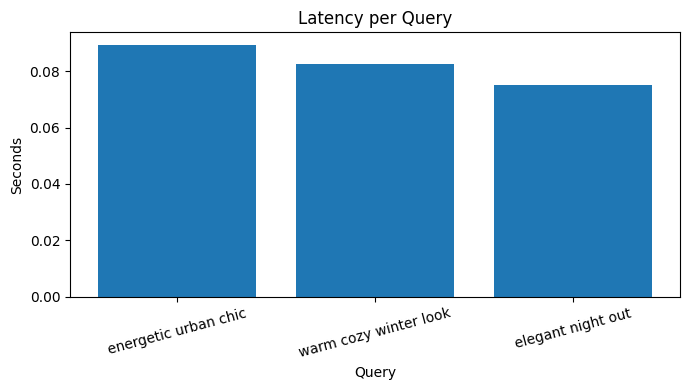

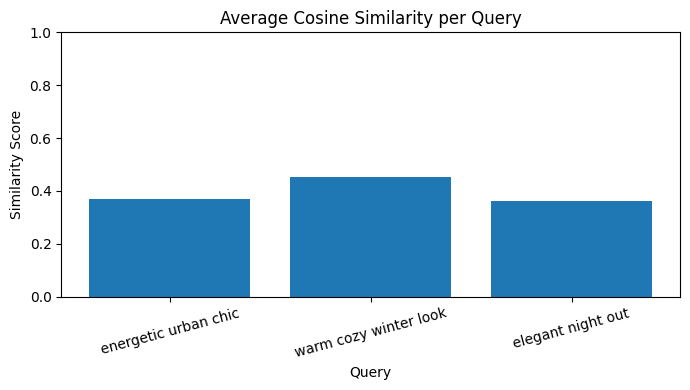

<Figure size 640x480 with 0 Axes>

In [26]:
# Define test queries (you can change these)
test_queries = [
"energetic urban chic",
"warm cozy winter look",
"elegant night out",
]


avg_scores, latencies = evaluate_queries(
test_queries,
embed_fn=get_embedding,
match_fn=vibe_matcher,
df=df,
top_n=3,
)


# Save plots and show
plot_latency(test_queries, latencies)
plot_similarity(test_queries, avg_scores)


# Optionally save the latency plot file
plt.savefig(ASSETS_DIR / "latency_plot.png")

In [27]:
# Simple threshold-based fallback
THRESHOLD = 0.30


def match_with_fallback(query: str, top_n: int = 3, threshold: float = THRESHOLD):
    res = match_query_text(query, top_n=top_n)
    if res['score'].max() < threshold:
        print("No strong match found (all scores < {:.2f}). Consider broadening the vibe.".format(threshold))
        return res
    return res


# Example edge-case query
print("Edge-case query: 'alien spaceship formal' -> expected poor match")
print(match_with_fallback("alien spaceship formal", top_n=3))

Edge-case query: 'alien spaceship formal' -> expected poor match
                   name                                               desc  \
4  Elegant Black Blazer  Sharp tailoring and subtle sheen for formal ev...   
7          Denim Jacket  Classic blue denim with a rugged feel for a ti...   
0            Boho Dress  Flowy, earthy tones perfect for outdoor festiv...   

                         vibe     score  
4  [formal, elegant, evening]  0.598344  
7    [casual, vintage, urban]  0.475513  
0       [boho, free-spirited]  0.412757  
